# Workflow for Customer Segmentation with PySpark

In [1]:
!pip install --upgrade pyspark


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.4-py2.py3-none-any.whl size=317849766 sha256=ae7375230f5fc19f5ca6f7a87731e308b418c28dcc987fb8687ad9d5281c80bc
  Stored in directory: /root/.cache/pip/wheels/d9/1c/98/31e395a42d1735d18d42124971ecbbade844b50bb9845b6f4a
Successfully built pyspark
  Attempting uninstall: pyspark
    Found existing installation: pyspark 3.5.3
    Uninstalling pyspark-3.5.3:
      Successfully uninstalled pyspark-3.5.3


In [16]:
# Import required libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as _sum, countDistinct, datediff, to_date, lit, when, avg, udf, isnan, count
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType, FloatType, DoubleType, StringType
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator, ClusteringEvaluator
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


# 1. Data Ingestion and Preparation

## 1.1 Data Ingestion

In [3]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("Customer Segmentation and Predictive Modeling") \
    .master("local[*]") \
    .config("spark.executor.memory", "6g") \
    .config("spark.driver.memory", "6g") \
    .config("spark.executor.cores", "4") \
    .config("spark.sql.shuffle.partitions", "1000") \
    .config("spark.executor.extraJavaOptions", "-XX:+UseG1GC") \
    .config("spark.driver.extraJavaOptions", "-XX:+UseG1GC") \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .getOrCreate()


In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
# Load data
data_path = '/content/drive/MyDrive/IU_BDT/Online-Retail.csv'
data = spark.read.csv(data_path, header=True, inferSchema=True)


In [12]:
# Print schema
data.printSchema()


root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)



In [14]:
# EDA
print("Shape of the DataFrame:", (data.count(), len(data.columns)))
data.show(5)


Shape of the DataFrame: (541909, 8)
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
only showing top 5 rows



In [11]:
data.summary().show()

+-------+-----------------+------------------+--------------------+------------------+---------------+-----------------+------------------+-----------+
|summary|        InvoiceNo|         StockCode|         Description|          Quantity|    InvoiceDate|        UnitPrice|        CustomerID|    Country|
+-------+-----------------+------------------+--------------------+------------------+---------------+-----------------+------------------+-----------+
|  count|           541909|            541909|              540455|            541909|         541909|           541909|            406829|     541909|
|   mean| 559965.752026781|27623.240210938104|             20713.0|  9.55224954743324|           NULL|4.611113626083021|15287.690570239585|       NULL|
| stddev|13428.41728079881|16799.737628427694|                NULL|218.08115785023472|           NULL|96.75985306117944|1713.6003033215934|       NULL|
|    min|           536365|             10002| 4 PURPLE FLOCK D...|            -80995|1/

In [18]:
# Check missing values
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
|        0|        0|       1454|       0|          0|        0|    135080|      0|
+---------+---------+-----------+--------+-----------+---------+----------+-------+



## 1.2 Data Cleaning

In [19]:
from pyspark.sql.functions import col, when, mean, median, mode, count


In [20]:
# Replace null values in numerical columns with median
numerical_cols = ["Quantity", "UnitPrice"]
for col_name in numerical_cols:
    data_cleaned = data.withColumn(col_name, when(col(col_name).isNull(), median(col(col_name)).over(Window.partitionBy())).otherwise(col(col_name)))

# Replace null values in categorical columns with mode
categorical_cols = ["InvoiceNo", "StockCode", "Description", "CustomerID", "Country"]
for col_name in categorical_cols:
    data_cleaned = data.withColumn(col_name, when(col(col_name).isNull(), mode(col(col_name)).over(Window.partitionBy())).otherwise(col(col_name)))

# Add TotalPrice column
data_cleaned = data_cleaned.withColumn("TotalPrice", col("Quantity") * col("UnitPrice"))

# Convert InvoiceDate to DateType
data_cleaned = data_cleaned.withColumn("InvoiceDate", to_date(col("InvoiceDate"), "MM/dd/yyyy HH:mm"))


In [21]:
print("Shape of the DataFrame:", (data_cleaned.count(), len(data_cleaned.columns)))
data_cleaned.show(5)

Shape of the DataFrame: (541909, 9)
+---------+---------+--------------------+--------+-----------+---------+----------+--------------+------------------+
|InvoiceNo|StockCode|         Description|Quantity|InvoiceDate|UnitPrice|CustomerID|       Country|        TotalPrice|
+---------+---------+--------------------+--------+-----------+---------+----------+--------------+------------------+
|   536365|   85123A|WHITE HANGING HEA...|       6| 2010-12-01|     2.55|     17850|United Kingdom|15.299999999999999|
|   536365|    71053| WHITE METAL LANTERN|       6| 2010-12-01|     3.39|     17850|United Kingdom|             20.34|
|   536365|   84406B|CREAM CUPID HEART...|       8| 2010-12-01|     2.75|     17850|United Kingdom|              22.0|
|   536365|   84029G|KNITTED UNION FLA...|       6| 2010-12-01|     3.39|     17850|United Kingdom|             20.34|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6| 2010-12-01|     3.39|     17850|United Kingdom|             20.34|
+---------+-

In [22]:
import datetime
reference_date = datetime.date(2011, 12, 10)
from pyspark.sql.functions import log

In [23]:
# Feature Engineering: Calculate RFM features
rfm = data_cleaned.groupBy("CustomerID").agg(
    datediff(lit(reference_date), F.max(col("InvoiceDate"))).alias("Recency"),  #Recency
    countDistinct("InvoiceNo").alias("Frequency"),  #Frequency
    _sum("TotalPrice").alias("Monetary")  #Monetary
)


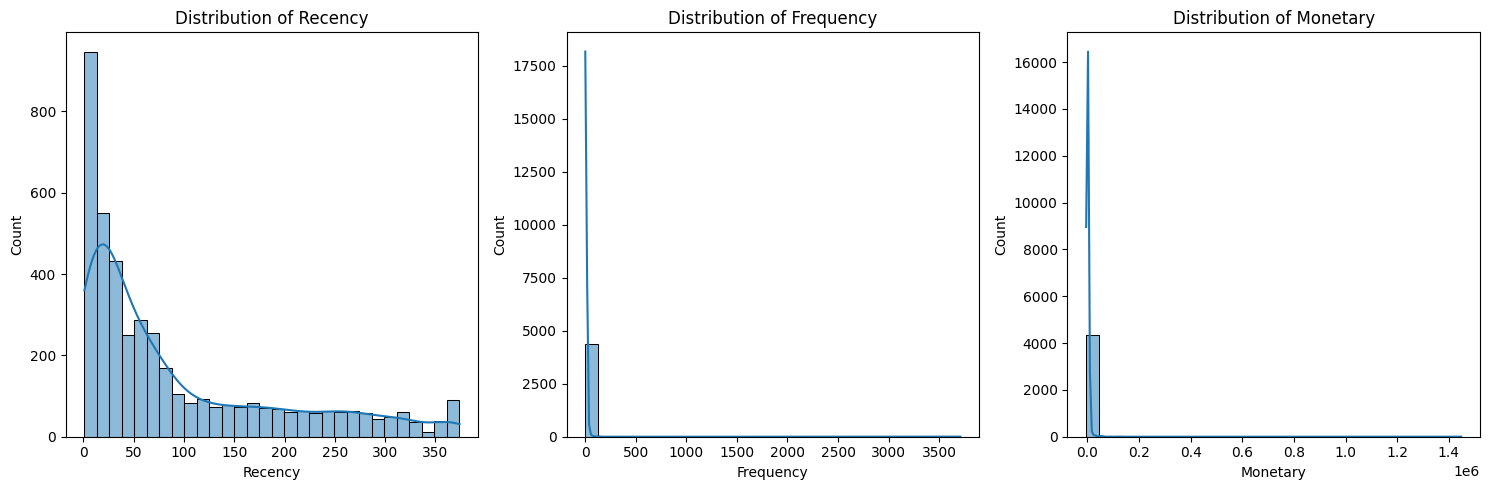

In [24]:
# Convert Spark DataFrame to Pandas for visualization
rfm_pd = rfm.toPandas()

# Distribution plots for RFM metrics
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(data=rfm_pd, x='Recency', bins=30, kde=True)
plt.title('Distribution of Recency')

plt.subplot(1, 3, 2)
sns.histplot(data=rfm_pd, x='Frequency', bins=30, kde=True)
plt.title('Distribution of Frequency')

plt.subplot(1, 3, 3)
sns.histplot(data=rfm_pd, x='Monetary', bins=30, kde=True)
plt.title('Distribution of Monetary')

plt.tight_layout()
plt.show()


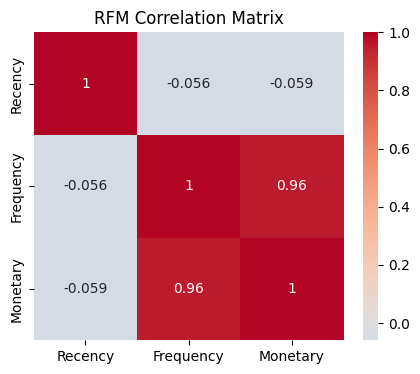

In [25]:
# Correlation matrix
corr_matrix = rfm_pd[['Recency', 'Frequency', 'Monetary']].corr()
plt.figure(figsize=(5, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('RFM Correlation Matrix')
plt.show()


In [26]:
# Apply log transformation to the Frequency and Monetary values
rfm = rfm.withColumn("Log_Frequency", log(rfm["Frequency"] + 1)) \
         .withColumn("Log_Monetary", log(rfm["Monetary"] + 1))

# Calculate RFM score (sum of Recency + Log_Frequency + Log_Monetary)
rfm = rfm.withColumn("RFM_Score", col("Recency") + col("Log_Frequency") + col("Log_Monetary"))

print("Shape of the DataFrame:", (rfm.count(), len(rfm.columns)))
rfm.show(5)


Shape of the DataFrame: (4373, 7)
+----------+-------+---------+------------------+------------------+------------------+------------------+
|CustomerID|Recency|Frequency|          Monetary|     Log_Frequency|      Log_Monetary|         RFM_Score|
+----------+-------+---------+------------------+------------------+------------------+------------------+
|     16339|    285|        1|109.95000000000002|0.6931471805599453| 4.709079649378603|290.40222682993857|
|     16503|    107|        5|1421.4299999999998| 1.791759469228055|7.2601219556508365|116.05188142487889|
|     12626|     24|       13|6388.3499999999985|2.6390573296152584| 8.762387820757855|35.401445150373114|
|     14423|    219|        1|             265.2|0.6931471805599453|5.5842479059610115|225.27739508652095|
|     17809|     17|       15| 4627.620000000001| 2.772588722239781| 8.440014046497208| 28.21260276873699|
+----------+-------+---------+------------------+------------------+------------------+------------------+
onl

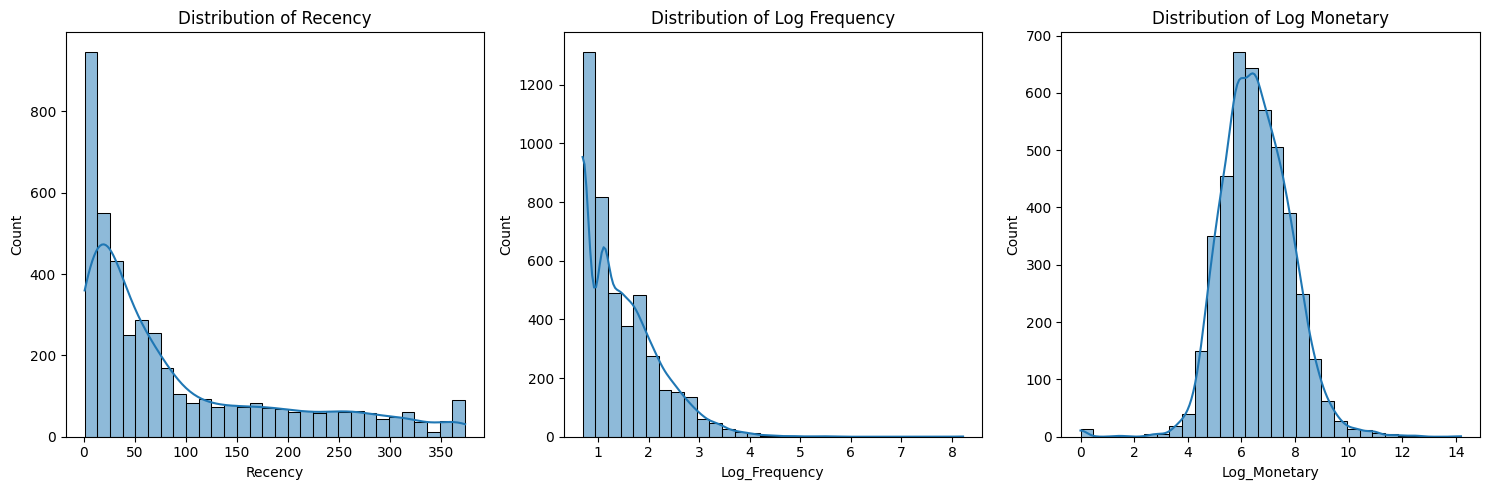

In [27]:
# Convert Spark DataFrame to Pandas for visualization
rfm_pd = rfm.toPandas()

# Distribution plots for RFM metrics
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(data=rfm_pd, x='Recency', bins=30, kde=True)
plt.title('Distribution of Recency')

plt.subplot(1, 3, 2)
sns.histplot(data=rfm_pd, x='Log_Frequency', bins=30, kde=True)
plt.title('Distribution of Log Frequency')

plt.subplot(1, 3, 3)
sns.histplot(data=rfm_pd, x='Log_Monetary', bins=30, kde=True)
plt.title('Distribution of Log Monetary')

plt.tight_layout()
plt.show()


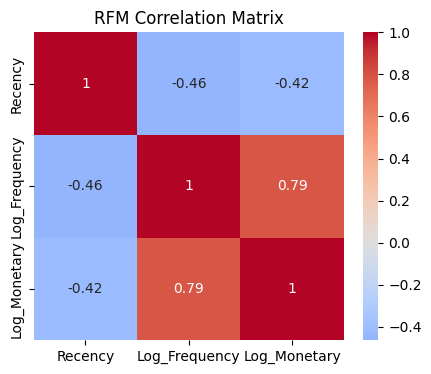

In [28]:
# Correlation matrix
corr_matrix = rfm_pd[['Recency', 'Log_Frequency', 'Log_Monetary']].corr()
plt.figure(figsize=(5, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('RFM Correlation Matrix')
plt.show()


In [29]:
# Assemble features for clustering
assembler = VectorAssembler(inputCols=["Recency", "Log_Frequency", "Log_Monetary", "RFM_Score"],
                                outputCol="features",
                                handleInvalid="skip")
rfm_features = assembler.transform(rfm)

# Scale the features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
rfm_scaled = scaler.fit(rfm_features).transform(rfm_features)
rfm_scaled.select("scaledFeatures").show(5, truncate=False)


+-------------------------------------------------------------------------------+
|scaledFeatures                                                                 |
+-------------------------------------------------------------------------------+
|[1.958479630593382,-1.0168185776691991,-1.4166988049441471,1.9495416138836985] |
|[0.1626865184632786,0.4593619119540323,0.5430402271631296,0.17481862809296664] |
|[-0.6746776855075,1.5978568872099972,1.6970975492287466,-0.6461271677864966]   |
|[1.2926237575563775,-1.0168185776691991,-0.7443848304291375,1.2866319100211732]|
|[-0.7452987629508186,1.7772799999657372,1.4494464354886862,-0.7193028405176043]|
+-------------------------------------------------------------------------------+
only showing top 5 rows



# 2. Customer Segmentation using K-means CLustering

In [30]:
# Grid Search or Random Search for optimizing k in K-Means
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType


In [31]:
# Function to calculate Euclidean distance squared
def squared_euclidean_distance(point, center):
    return float(np.sum((np.array(point) - np.array(center)) ** 2))

# Register the function as a UDF
squared_distance_udf = udf(squared_euclidean_distance, DoubleType())


In [32]:
# Define a range of k values for testing
k_values = range(2, 11)

# Initialize K-Means models for different k values
evaluation_metrics = []

for k in k_values:
    kmeans = KMeans(k=k, seed=42, featuresCol="scaledFeatures", predictionCol="cluster")
    kmeans_model = kmeans.fit(rfm_scaled)
    rfm_clusters = kmeans_model.transform(rfm_scaled)

    # Get cluster centers
    cluster_centers = kmeans_model.clusterCenters()

    # Add a column for squared Euclidean distance to the cluster center
    def calculate_wcss(row):
        cluster_center = cluster_centers[row['cluster']]
        return squared_euclidean_distance(row['scaledFeatures'], cluster_center)

    # Apply the WCSS function to calculate squared distances
    rfm_clusters = rfm_clusters.withColumn("squared_distance", F.udf(lambda row: calculate_wcss(row), DoubleType())(F.struct("scaledFeatures", "cluster")))

    # Calculate WCSS (sum of squared distances)
    wcss = rfm_clusters.agg(F.sum("squared_distance")).collect()[0][0]

    # Evaluate Silhouette Score
    evaluator_silhouette = ClusteringEvaluator(featuresCol="scaledFeatures", predictionCol="cluster", metricName="silhouette")
    silhouette_score = evaluator_silhouette.evaluate(rfm_clusters)

    # Append results to the list
    evaluation_metrics.append({
        "k": k,
        "WCSS": wcss,
        "SilhouetteScore": silhouette_score
    })

# Convert the results to a pandas DataFrame
metrics_df = pd.DataFrame(evaluation_metrics)

# Display the results
display(metrics_df)


,k,WCSS,SilhouetteScore
0,2,9098.042832,0.659259
1,3,5373.192989,0.607938
2,4,4325.433031,0.534486
3,5,3547.593867,0.523820
4,6,3205.983405,0.518047
5,7,2811.993119,0.464416
6,8,2671.011239,0.446677
7,9,2469.125028,0.457356
8,10,2252.888651,0.396499


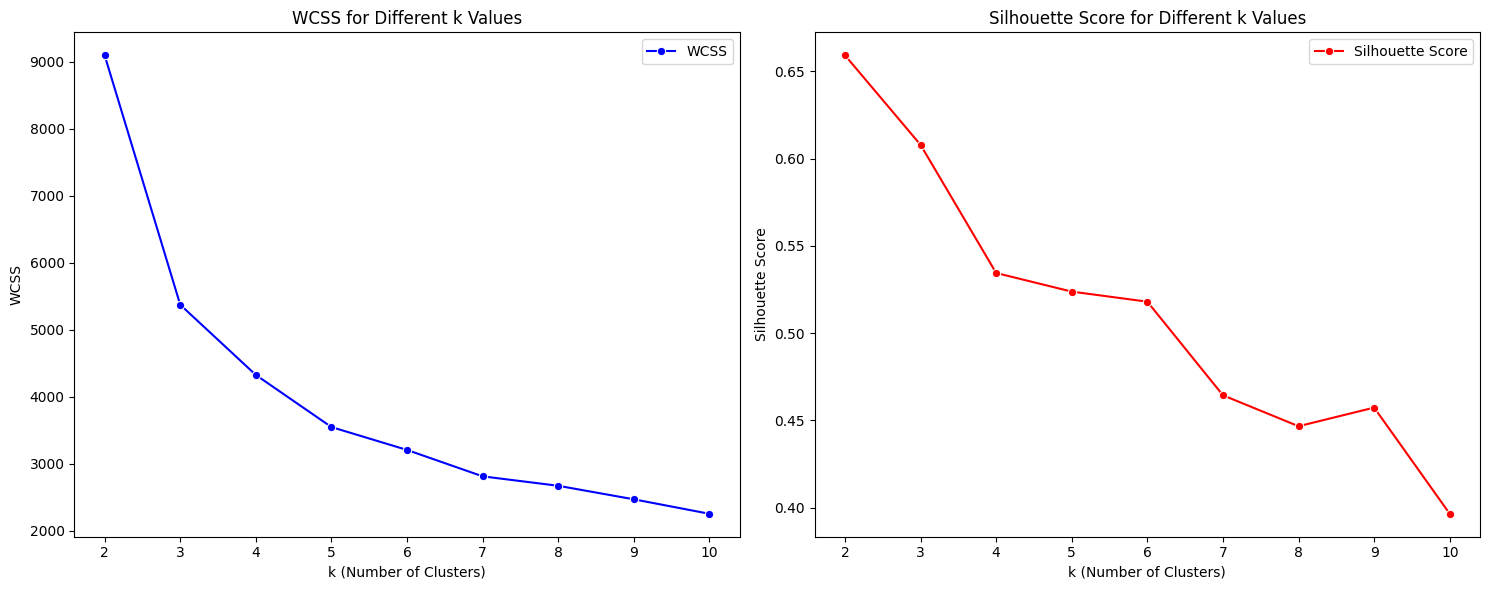

In [33]:
# Plot WCSS and Silhouette Score comparisons
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot WCSS values
sns.lineplot(x='k', y='WCSS', data=metrics_df, ax=ax1, marker='o', color='b', label='WCSS')
ax1.set_title('WCSS for Different k Values')
ax1.set_xlabel('k (Number of Clusters)')
ax1.set_ylabel('WCSS')

# Plot Silhouette Scores
sns.lineplot(x='k', y='SilhouetteScore', data=metrics_df, ax=ax2, marker='o', color='r', label='Silhouette Score')
ax2.set_title('Silhouette Score for Different k Values')
ax2.set_xlabel('k (Number of Clusters)')
ax2.set_ylabel('Silhouette Score')

# Display the plots
plt.tight_layout()
plt.show()


In [34]:
# Select the best k based on silhouette scores or elbow curve
best_k = 3

print('The optimal number of clusters:', best_k)

# Fit KMeans with the optimal k
kmeans = KMeans(k=best_k, seed=42, featuresCol="scaledFeatures", predictionCol="cluster")
kmeans_model = kmeans.fit(rfm_scaled)
rfm_clusters = kmeans_model.transform(rfm_scaled)

rfm_clusters_df = pd.DataFrame(rfm_clusters.groupBy("cluster").count().toPandas())
display(rfm_clusters_df)


The optimal number of clusters: 3


,cluster,count
0,1,1999
1,2,985
2,0,1348


In [35]:
# Visualize cluster distributions
print("Shape of the DataFrame:", (rfm_clusters.count(), len(rfm_clusters.columns)))
rfm_clusters.select("CustomerID", "Recency", "Log_Frequency", "Log_Monetary", "cluster").show(5)


Shape of the DataFrame: (4332, 10)
+----------+-------+------------------+------------------+-------+
|CustomerID|Recency|     Log_Frequency|      Log_Monetary|cluster|
+----------+-------+------------------+------------------+-------+
|     16339|    285|0.6931471805599453| 4.709079649378603|      2|
|     16503|    107| 1.791759469228055|7.2601219556508365|      0|
|     12626|     24|2.6390573296152584| 8.762387820757855|      0|
|     14423|    219|0.6931471805599453|5.5842479059610115|      2|
|     17809|     17| 2.772588722239781| 8.440014046497208|      0|
+----------+-------+------------------+------------------+-------+
only showing top 5 rows



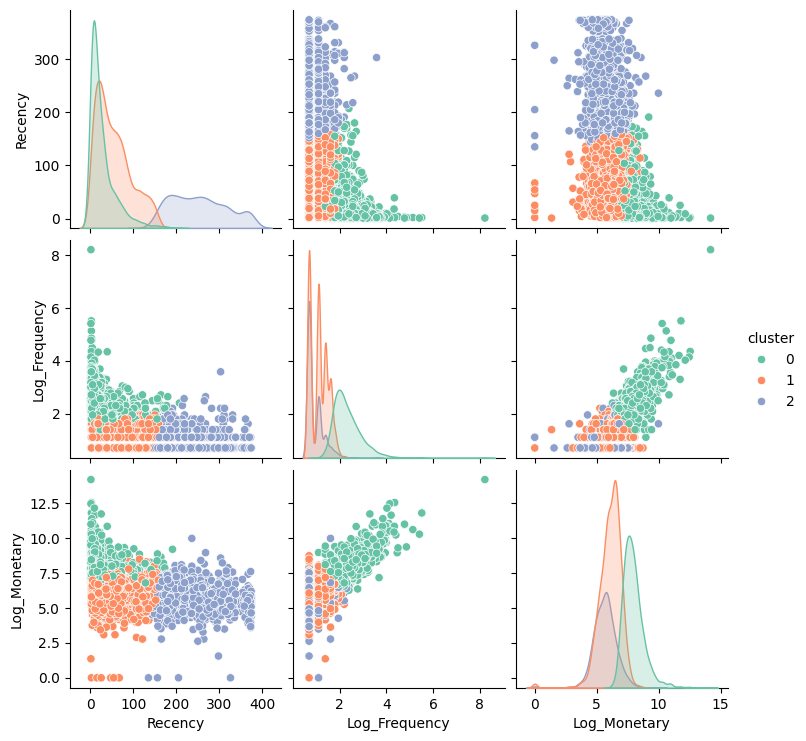

In [36]:
# Convert PySpark DataFrame to Pandas for visualization
rfm_pd = rfm_clusters.select("Recency", "Log_Frequency", "Log_Monetary", "cluster").toPandas()

# Pairplot for cluster visualization
sns.pairplot(rfm_pd, hue="cluster", diag_kind="kde", palette="Set2")
plt.show()


In [37]:
import plotly.graph_objs as go
import plotly.offline as py


In [38]:
# Convert the PySpark DataFrame to Pandas to work with Plotly
rfm_pd = rfm_clusters.select("Recency", "Log_Frequency", "Log_Monetary", "cluster").toPandas()

# Create the 3D scatter plot
trace1 = go.Scatter3d(
    x=rfm_pd['Recency'],        # Recency on the x-axis
    y=rfm_pd['Log_Frequency'],  # Log(Frequency) on the y-axis
    z=rfm_pd['Log_Monetary'],   # Log(Monetary) on the z-axis
    mode='markers',
    marker=dict(
        color=rfm_pd['cluster'],  # Color by cluster labels
        size=10,  # Marker size
        line=dict(
            color=rfm_pd['cluster'],  # Marker border color by cluster
            width=2  # Border width
        ),
        opacity=0.8  # Set transparency level
    )
)

# Layout for the plot
layout = go.Layout(
    title='3D Visualization of RFM Clusters',
    scene=dict(
        xaxis=dict(title='Recency'),
        yaxis=dict(title='Log(Frequency)'),
        zaxis=dict(title='Log(Monetary)')
    )
)

# Create figure and plot
fig = go.Figure(data=[trace1], layout=layout)
py.offline.iplot(fig)  # Display the interactive plot


In [39]:
# Mean RFM Values per Cluster
# Calculate mean RFM metrics per cluster
mean_rfm_per_cluster = rfm_clusters.groupBy("cluster").agg(
    F.avg("Recency").alias("Mean_Recency"),
    F.avg("Log_Frequency").alias("Mean_Frequency"),
    F.avg("Log_Monetary").alias("Mean_Monetary"),
    F.avg("RFM_Score").alias("Mean_RFM_Score")
)

mean_rfm_per_cluster_df = pd.DataFrame(mean_rfm_per_cluster.toPandas())
display(mean_rfm_per_cluster_df)

,cluster,Mean_Recency,Mean_Frequency,Mean_Monetary,Mean_RFM_Score
0,1,53.901951,1.113659,6.068365,61.083975
1,2,253.004061,0.935870,5.641950,259.581881
2,0,27.232196,2.324101,7.938147,37.494444


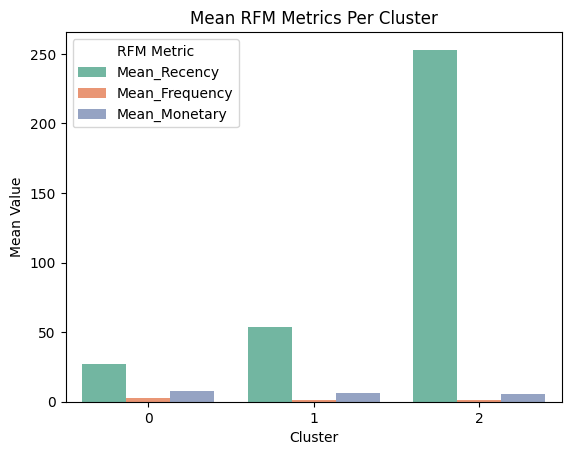

In [40]:
# Visualize Mean RFM Values per Cluster
mean_rfm_pd = mean_rfm_per_cluster.toPandas()
mean_rfm_pd_melted = mean_rfm_pd.melt(id_vars=["cluster"],
                                      value_vars=["Mean_Recency", "Mean_Frequency", "Mean_Monetary"],
                                      var_name="Metric", value_name="Value")

sns.barplot(x="cluster", y="Value", hue="Metric", data=mean_rfm_pd_melted, palette="Set2")
plt.title("Mean RFM Metrics Per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Mean Value")
plt.legend(title="RFM Metric")
plt.show()


In [41]:
# Collecting mean RFM score for each cluster
mean_rfm_dict = mean_rfm_per_cluster.collect()
mean_rfm_dict = {row['cluster']: row['Mean_RFM_Score'] for row in mean_rfm_dict}


In [42]:
display(mean_rfm_dict)

{1: 61.083974531231235, 2: 259.5818808285286, 0: 37.49444415495142}

In [43]:
# Function to label customers based on RFM score
def label_customer(rfm_score, mean_rfm_score):
    if rfm_score > mean_rfm_score * 1.2:  # Elite if score is significantly higher
        return "Elite"
    elif rfm_score < mean_rfm_score * 0.8:  # Dormant if score is significantly lower
        return "Dormant"
    else:  # Standard customers are in the middle range
        return "Standard"

# Register the function as a UDF
label_udf = F.udf(lambda rfm_score, cluster: label_customer(rfm_score, mean_rfm_dict[cluster]), StringType())

# Apply the UDF to label each customer
rfm_clusters = rfm_clusters.withColumn("Customer_Type", label_udf(col("RFM_Score"), col("cluster")))

# Show labeled customers
rfm_clusters.select("CustomerID", "RFM_Score", "cluster", "Customer_Type").show(5)


+----------+------------------+-------+-------------+
|CustomerID|         RFM_Score|cluster|Customer_Type|
+----------+------------------+-------+-------------+
|     16339|290.40222682993857|      2|     Standard|
|     16503|116.05188142487889|      0|        Elite|
|     12626|35.401445150373114|      0|     Standard|
|     14423|225.27739508652095|      2|     Standard|
|     17809| 28.21260276873699|      0|      Dormant|
+----------+------------------+-------+-------------+
only showing top 5 rows



In [44]:
# Calculate the count of each type of customer per cluster
display(rfm_clusters.groupBy("cluster", "Customer_Type").count().toPandas().sort_values(by='count', ascending=False))


,cluster,Customer_Type,count
5,1,Dormant,940
3,0,Dormant,759
1,1,Elite,661
4,2,Standard,484
7,1,Standard,398
2,0,Elite,338
0,2,Dormant,264
6,0,Standard,251
8,2,Elite,237


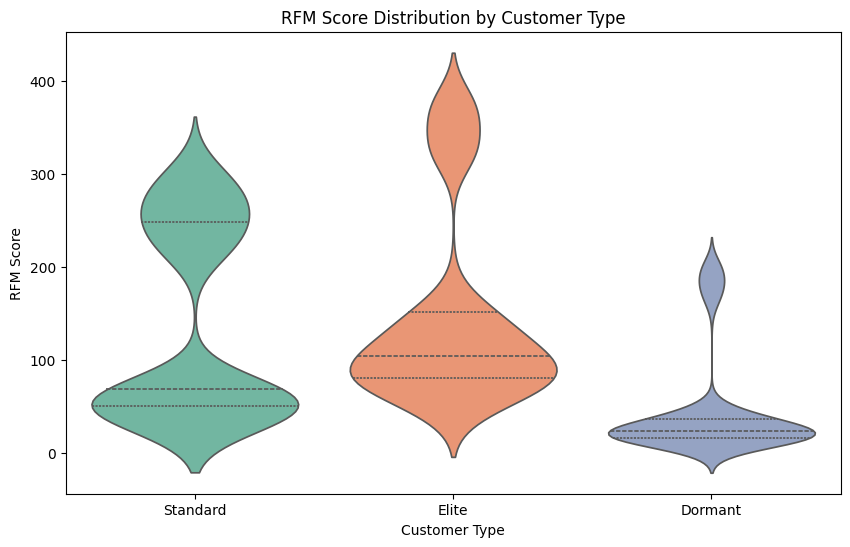

In [45]:
# Convert the Spark DataFrame to Pandas for visualization
rfm_pd = rfm_clusters.select("RFM_Score", "Customer_Type").toPandas()

# Create a violin plot to visualize the distribution of RFM scores across customer types
plt.figure(figsize=(10, 6))
sns.violinplot(x="Customer_Type", y="RFM_Score", data=rfm_pd, inner="quart", palette='Set2', hue="Customer_Type")
plt.title('RFM Score Distribution by Customer Type')
plt.xlabel('Customer Type')
plt.ylabel('RFM Score')
plt.show()


**Elite Customers:**
- Highest RFM Scores: Elite customers have the highest RFM scores, concentrated in the upper range (200–400), with a long tail extending to the maximum score.
- Broad Distribution: The distribution is wide, indicating diversity in engagement levels, but it skews toward higher values.
- Key Insight: This group represents the most valuable customers, consistently scoring high in recency, frequency, and monetary value. They are the core group for retention and loyalty programs.

**Standard Customers:**
- Moderate RFM Scores: The RFM scores for standard customers are generally in the mid-range (50–250).
- Balanced Distribution: The distribution is fairly symmetrical, showing a mix of moderately engaged customers. The peak occurs around the median score.
- Key Insight: Standard customers are active but less valuable compared to elite customers. They have potential for upselling and nurturing to convert them into elite customers.

**Dormant Customers:**
- Lowest RFM Scores: Dormant customers have the lowest RFM scores, almost entirely concentrated below 100.
- Narrow Distribution: The distribution is tightly packed, indicating little variability in their low scores.
- Key Insight: These customers are disengaged, with low recency, frequency, and monetary value. They are likely lapsed customers who need reactivation strategies or may no longer be worth targeting.

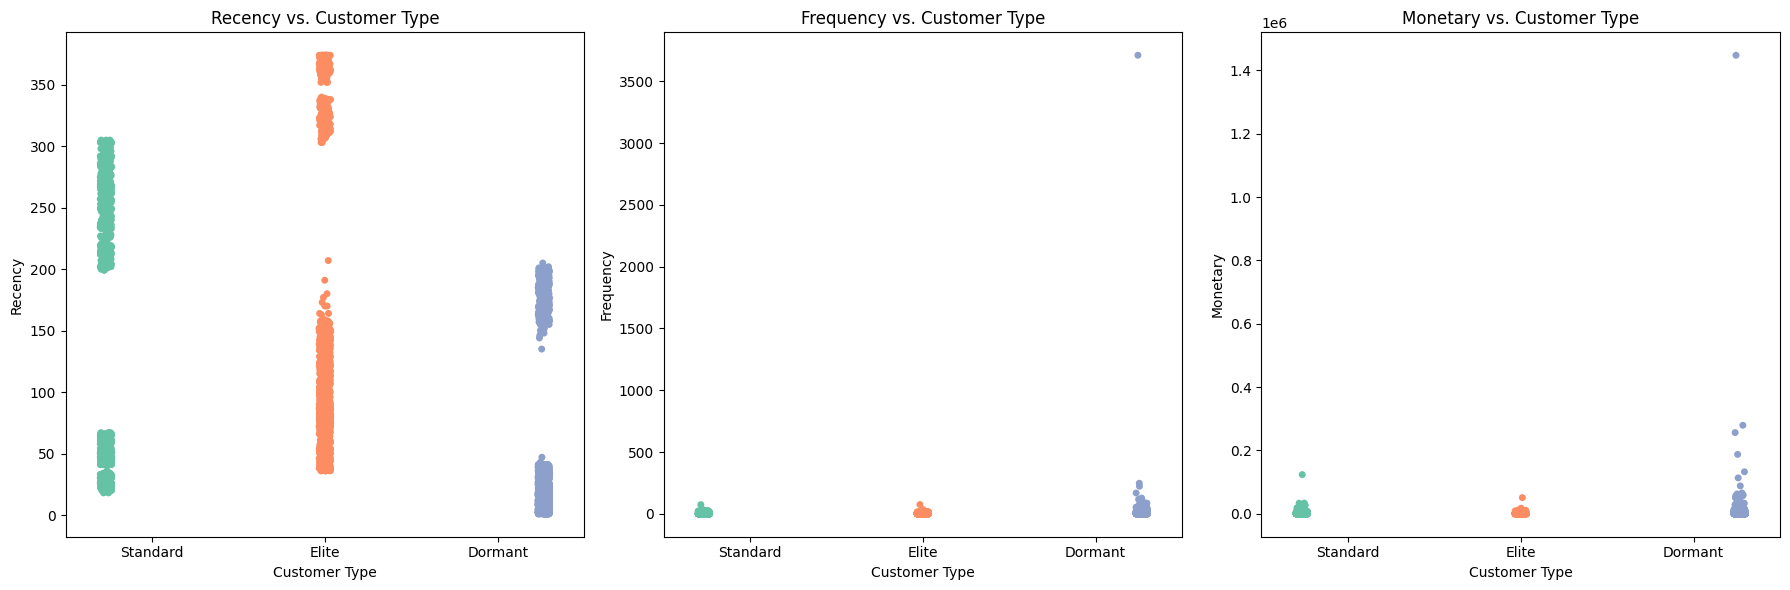

In [49]:
# Convert the Spark DataFrame to Pandas for visualization
rfm_pd = rfm_clusters.select("Recency", "Frequency", "Monetary", "Customer_Type").toPandas()

# Set up the plot grid
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Strip plot for Recency vs. Customer Type
sns.stripplot(data=rfm_pd, x="Customer_Type", y="Recency", hue="Customer_Type", palette='Set2', jitter=True, ax=axes[0], dodge=True, legend=False)
axes[0].set_title('Recency vs. Customer Type')
axes[0].set_xlabel('Customer Type')
axes[0].set_ylabel('Recency')

# Strip plot for Frequency vs. Customer Type
sns.stripplot(data=rfm_pd, x="Customer_Type", y="Frequency", hue="Customer_Type", palette='Set2', jitter=True, ax=axes[1], dodge=True, legend=False)
axes[1].set_title('Frequency vs. Customer Type')
axes[1].set_xlabel('Customer Type')
axes[1].set_ylabel('Frequency')

# Strip plot for Monetary vs. Customer Type
sns.stripplot(data=rfm_pd, x="Customer_Type", y="Monetary", hue="Customer_Type", palette='Set2', jitter=True, ax=axes[2], dodge=True, legend=False)
axes[2].set_title('Monetary vs. Customer Type')
axes[2].set_xlabel('Customer Type')
axes[2].set_ylabel('Monetary')

# Show the plots
plt.tight_layout()
plt.show()


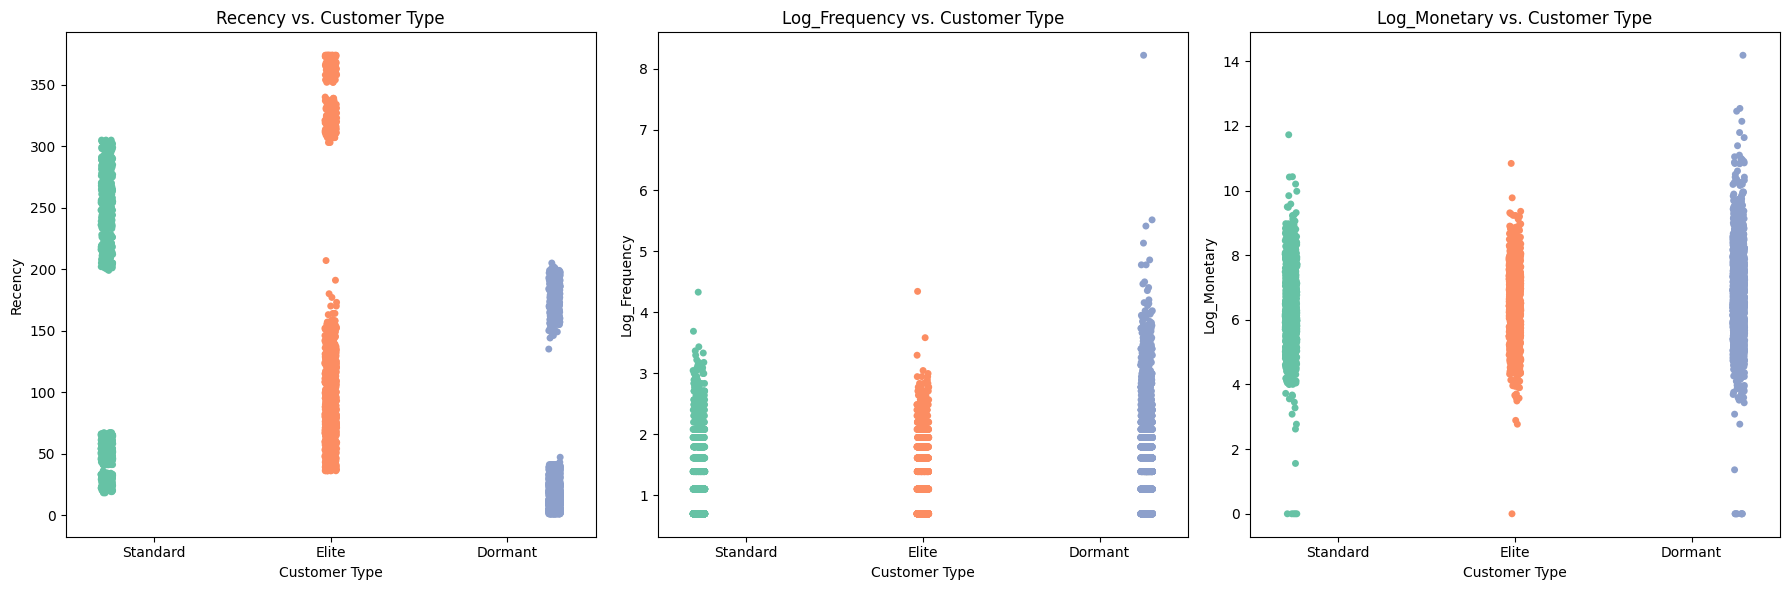

In [48]:
# Convert the Spark DataFrame to Pandas for visualization
rfm_pd = rfm_clusters.select("Recency", "Log_Frequency", "Log_Monetary", "Customer_Type").toPandas()

# Set up the plot grid
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Strip plot for Recency vs. Customer Type
sns.stripplot(data=rfm_pd, x="Customer_Type", y="Recency", hue="Customer_Type", palette='Set2', jitter=True, ax=axes[0], dodge=True, legend=False)
axes[0].set_title('Recency vs. Customer Type')
axes[0].set_xlabel('Customer Type')
axes[0].set_ylabel('Recency')

# Strip plot for Log_Frequency vs. Customer Type
sns.stripplot(data=rfm_pd, x="Customer_Type", y="Log_Frequency", hue="Customer_Type", palette='Set2', jitter=True, ax=axes[1], dodge=True, legend=False)
axes[1].set_title('Log_Frequency vs. Customer Type')
axes[1].set_xlabel('Customer Type')
axes[1].set_ylabel('Log_Frequency')

# Strip plot for Log_Monetary vs. Customer Type
sns.stripplot(data=rfm_pd, x="Customer_Type", y="Log_Monetary", hue="Customer_Type", palette='Set2', jitter=True, ax=axes[2], dodge=True, legend=False)
axes[2].set_title('Log_Monetary vs. Customer Type')
axes[2].set_xlabel('Customer Type')
axes[2].set_ylabel('Log_Monetary')

# Show the plots
plt.tight_layout()
plt.show()


## Key Insights:
**Customer Type Characteristics:**
- Standard Customers are active but low-value customers with low recency, frequency, and monetary values.
- Elite Customers are high-value, frequent, and relatively recent purchasers. They are the core group for retention efforts.
- Dormant Customers are lapsed customers with high recency and low frequency and monetary values. They may need reactivation campaigns.

**Elite Customers as Top Priority:**
- Elite customers exhibit the highest monetary and frequency values, making them the most valuable segment. Retaining and nurturing this group can drive significant revenue.

**Dormant Customers Require Strategy:**
- Dormant customers show high recency and low frequency/monetary values, but some outliers suggest potential for reactivation. Target these outliers with personalized win-back campaigns.

**Standard Customers Show Growth Potential:**
- Standard customers are recent purchasers but with low spending and frequency. They may be upsold or converted into elite customers with the right incentives.

## Recommendations:
**Focus on Elite Customers:**
- Provide personalized offers, loyalty programs, and exclusive rewards to maintain engagement and maximize their lifetime value.

**Reactivate Dormant Customers:**
- Use targeted win-back campaigns with discounts or reminders of past purchases. Focus on outliers with higher past monetary values.

**Upsell to Standard Customers:**
- Encourage higher spending and frequency through promotions, cross-selling, or bundles tailored to their needs.

**Monitor Customer Lifecycle:**
- Regularly analyze transitions between these groups to identify trends and opportunities (e.g., Standard to Elite, Elite to Dormant).


# 3. Predictive Model

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.linalg import Vectors
from pyspark.mllib.evaluation import MulticlassMetrics


In [ ]:
def create_churn_dummy(customer_type):
    if customer_type == 'Dormant':
        return 1  # Churned
    else:
        return 0  # Active

# Apply the churn dummy function
churn_udf = F.udf(create_churn_dummy, IntegerType())
rfm_clusters = rfm_clusters.withColumn("Churn", churn_udf(rfm_clusters["Customer_Type"]))


In [ ]:
rfm_clusters.show(5)

+----------+-------+---------+------------------+------------------+------------------+------------------+--------------------+--------------------+-------+-------------+-----+
|CustomerID|Recency|Frequency|          Monetary|     Log_Frequency|      Log_Monetary|         RFM_Score|            features|      scaledFeatures|cluster|Customer_Type|Churn|
+----------+-------+---------+------------------+------------------+------------------+------------------+--------------------+--------------------+-------+-------------+-----+
|     16339|    285|        1|109.95000000000002|0.6931471805599453| 4.709079649378603|290.40222682993857|[285.0,0.69314718...|[1.95847963059338...|      2|     Standard|    0|
|     16503|    107|        5|1421.4299999999998| 1.791759469228055|7.2601219556508365|116.05188142487889|[107.0,1.79175946...|[0.16268651846327...|      0|        Elite|    0|
|     12626|     24|       13|6388.3499999999985|2.6390573296152584| 8.762387820757855|35.401445150373114|[24.0,2.6

In [ ]:
# Prepare the features and labels (scaled features and churn column)
rfm_scaled_features = rfm_clusters.select("scaledFeatures", "Churn")


In [ ]:
train_data, test_data = rfm_scaled_features.randomSplit([0.8, 0.2], seed=42)


## 3.1 Random Forest

In [ ]:
# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(labelCol="Churn", featuresCol="scaledFeatures")

# Set up the parameter grid for hyperparameter tuning
param_grid = (ParamGridBuilder()
              .addGrid(rf_classifier.numTrees, [10, 15])
              .addGrid(rf_classifier.maxDepth, [3, 5])
              .build())

# Initialize the BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="Churn")

# Initialize CrossValidator for hyperparameter tuning
crossval = CrossValidator(estimator=rf_classifier,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=3)


In [ ]:
# Train the model using cross-validation
cv_rf_model = crossval.fit(train_data)


In [ ]:
# Get the best model from cross-validation
best_rf_model = cv_rf_model.bestModel

# Make predictions on the test set
cv_predictions = best_rf_model.transform(test_data)

# Evaluate the model using AUC
cv_auc = evaluator.evaluate(cv_predictions)
print(f"Cross-validated Model AUC: {cv_auc}")


Cross-validated Model AUC: 0.9969186046511628


In [ ]:
# Evaluate other metrics: precision, recall, f1 score, support
# Collect predictions and true labels for confusion matrix and classification report
predictions_and_labels = cv_predictions.select("prediction", "Churn").rdd.map(lambda row: (float(row.prediction), float(row.Churn)))

# Convert RDD to Pandas DataFrame for sklearn's classification_report
predicted_labels = [int(x[0]) for x in predictions_and_labels.collect()]
true_labels = [int(x[1]) for x in predictions_and_labels.collect()]

# Print the classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=["Active", "Churned"]))


Classification Report:
              precision    recall  f1-score   support

      Active       0.99      0.97      0.98       475
     Churned       0.95      0.98      0.97       344

    accuracy                           0.97       819
   macro avg       0.97      0.97      0.97       819
weighted avg       0.97      0.97      0.97       819



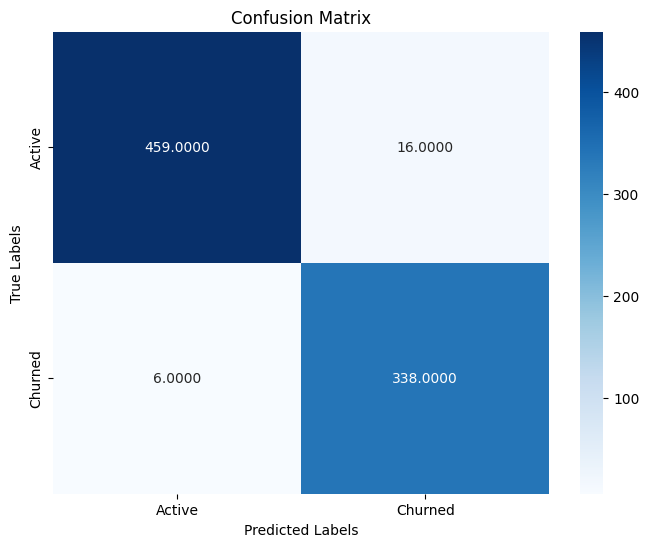

In [ ]:
# Generate confusion matrix
metrics = MulticlassMetrics(predictions_and_labels)
conf_matrix = metrics.confusionMatrix().toArray()

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt=".4f", cmap="Blues",
            xticklabels=["Active", "Churned"],
            yticklabels=["Active", "Churned"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


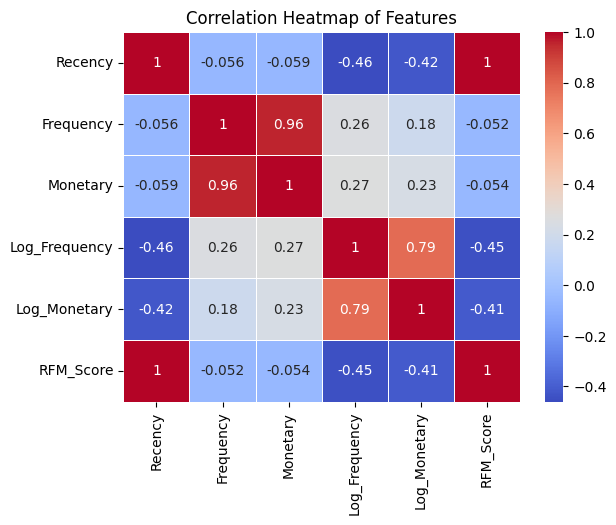

In [ ]:
# Generate heatmap for feature correlations
# Collect the features into a Pandas DataFrame for correlation plot
rfm_df = rfm_clusters.select("Recency", "Frequency", "Monetary", "Log_Frequency", "Log_Monetary", "RFM_Score").toPandas()
correlation_matrix = rfm_df.corr()

# Plot the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of Features")
plt.show()


## 3.2 Gradient Boosting Machines

In [ ]:
# Initialize the Gradient Boosted Tree Classifier
gbt_classifier = GBTClassifier(labelCol="Churn", featuresCol="scaledFeatures")

# Set up the parameter grid for hyperparameter tuning
param_grid = (ParamGridBuilder()
              .addGrid(gbt_classifier.maxIter, [5, 10])
              .addGrid(gbt_classifier.maxDepth, [3, 5])
              .addGrid(gbt_classifier.stepSize, [0.1])
              .build())

# Initialize the BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="Churn")

# Initialize CrossValidator for hyperparameter tuning
crossval = CrossValidator(estimator=gbt_classifier,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=3)


In [ ]:
# Train the model using cross-validation
cv_gbt_model = crossval.fit(train_data)


In [ ]:
# Get the best model from cross-validation
best_gbt_model = cv_gbt_model.bestModel

# Make predictions on the test set
cv_predictions = best_gbt_model.transform(test_data)

# Evaluate the model using AUC
cv_auc = evaluator.evaluate(cv_predictions)
print(f"Cross-validated Model AUC: {cv_auc}")


Cross-validated Model AUC: 0.99765605875153


In [ ]:
# Evaluate other metrics: precision, recall, f1 score, support
# Collect predictions and true labels for confusion matrix and classification report
predictions_and_labels = cv_predictions.select("prediction", "Churn").rdd.map(lambda row: (float(row.prediction), float(row.Churn)))

# Convert RDD to Pandas DataFrame for sklearn's classification_report
predicted_labels = [int(x[0]) for x in predictions_and_labels.collect()]
true_labels = [int(x[1]) for x in predictions_and_labels.collect()]

# Print the classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=["Active", "Churned"]))


Classification Report:
              precision    recall  f1-score   support

      Active       0.99      0.97      0.98       475
     Churned       0.97      0.98      0.97       344

    accuracy                           0.98       819
   macro avg       0.98      0.98      0.98       819
weighted avg       0.98      0.98      0.98       819



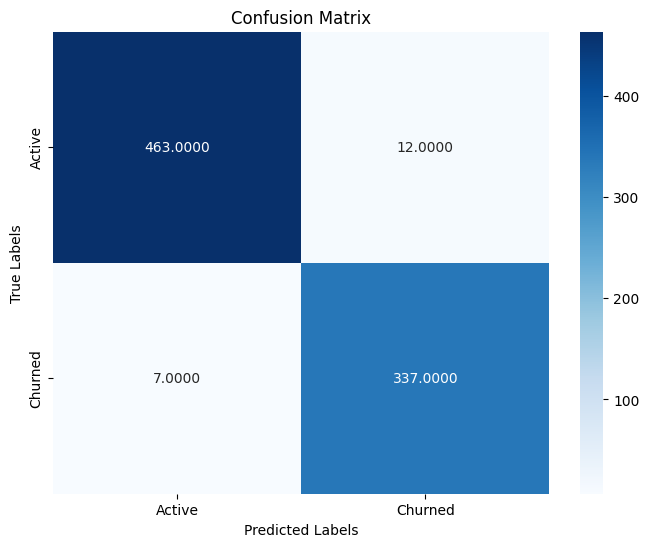

In [ ]:
# Generate confusion matrix
metrics = MulticlassMetrics(predictions_and_labels)
conf_matrix = metrics.confusionMatrix().toArray()

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt=".4f", cmap="Blues",
            xticklabels=["Active", "Churned"],
            yticklabels=["Active", "Churned"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


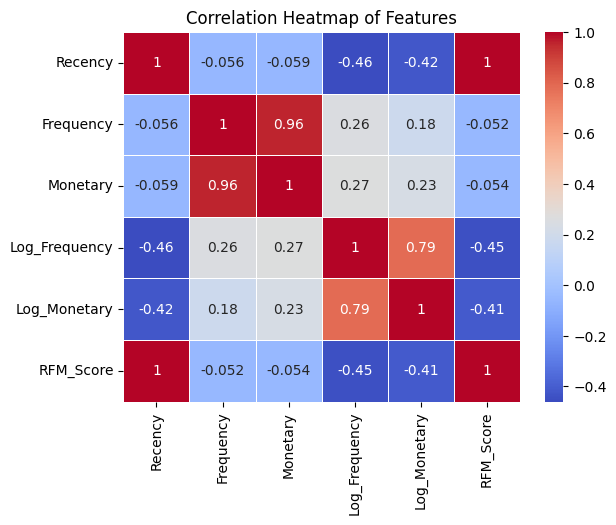

In [ ]:
# Generate heatmap for feature correlations
# Collect the features into a Pandas DataFrame for correlation plot
rfm_df = rfm_clusters.select("Recency", "Frequency", "Monetary", "Log_Frequency", "Log_Monetary", "RFM_Score").toPandas()
correlation_matrix = rfm_df.corr()

# Plot the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of Features")
plt.show()


# END